In [1]:
import os
import glob
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
import sys
sys.path.append(r"E:\Prem Lehar\Scripts\CURSOR scripts\ADNI_MRI\v9_ADNI_MRI_700_Without_Resampling_3DCNN_MedicalNet\MedicalNet")
from MedicalNet.model import generate_model


In [6]:
label_map = {'CN': 0, 'MCI': 1}

full_data = glob.glob("Dataset/*/*.nii.gz")
labels_str = [os.path.basename(os.path.dirname(p)) for p in full_data]
labels = [label_map[l] for l in labels_str]

train_path, test_path, train_labels, test_labels = train_test_split(
    full_data, labels, test_size=0.4, random_state=42, stratify=labels
)

In [7]:
class MRIDataset(Dataset):
    def __init__(self, file_paths, labels, target_shape=(112, 112, 16)):
        self.file_paths = file_paths
        self.labels = labels
        self.target_shape = target_shape
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label = self.labels[idx]

        # Load NIfTI
        img = nib.load(path).get_fdata()

        # Z-score normalization
        img = (img - img.mean()) / (img.std() + 1e-5)

        # Resample to [112, 112, 16]
        zoom_factors = [t / s for t, s in zip(self.target_shape, img.shape)]
        img = zoom(img, zoom_factors, order=1)

        # Shape: [C=1, D=16, H=112, W=112]
        img = np.expand_dims(img, axis=0)

        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [8]:
train_ds = MRIDataset(train_path, train_labels)
test_ds = MRIDataset(test_path, test_labels)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=2, num_workers=2)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Sets:
    model = 'resnet'
    model_depth = 10
    n_classes = 2  # CN vs MCI
    resnet_shortcut = 'B'
    conv1_t_size = 7
    conv1_t_stride = 1
    no_max_pool = False
    pretrain_path = './pretrain/resnet_10.pth'  # path to MedicalNet weights
    manual_seed = 42

sets = Sets()

In [12]:
torch.manual_seed(sets.manual_seed)
from MedicalNet.model import generate_model  # Make sure sys.path includes MedicalNet repo

model, parameters = generate_model(sets)
model = model.to(device)

AttributeError: 'Sets' object has no attribute 'input_W'

Epoch 1/10: 100%|██████████| 546/546 [03:56<00:00,  2.30it/s]


Epoch 1: Train Loss=0.7111, Train Acc=59.71% | Val Loss=0.6847, Val Acc=63.50%


Epoch 2/10: 100%|██████████| 546/546 [04:18<00:00,  2.11it/s]


Epoch 2: Train Loss=0.6766, Train Acc=61.54% | Val Loss=0.6621, Val Acc=63.50%


Epoch 3/10: 100%|██████████| 546/546 [04:24<00:00,  2.06it/s]


Epoch 3: Train Loss=0.6659, Train Acc=61.17% | Val Loss=0.6731, Val Acc=65.69%


Epoch 4/10: 100%|██████████| 546/546 [04:30<00:00,  2.02it/s]


Epoch 4: Train Loss=0.6894, Train Acc=59.16% | Val Loss=0.6571, Val Acc=63.50%


Epoch 5/10: 100%|██████████| 546/546 [04:23<00:00,  2.07it/s]


Epoch 5: Train Loss=0.6660, Train Acc=61.54% | Val Loss=0.7021, Val Acc=46.72%


Epoch 6/10: 100%|██████████| 546/546 [03:53<00:00,  2.34it/s]


Epoch 6: Train Loss=0.6653, Train Acc=63.37% | Val Loss=0.6457, Val Acc=63.50%


Epoch 7/10: 100%|██████████| 546/546 [03:47<00:00,  2.40it/s]


Epoch 7: Train Loss=0.6767, Train Acc=61.72% | Val Loss=0.6563, Val Acc=63.50%


Epoch 8/10: 100%|██████████| 546/546 [03:45<00:00,  2.42it/s]


Epoch 8: Train Loss=0.6674, Train Acc=61.36% | Val Loss=0.7082, Val Acc=47.45%


Epoch 9/10: 100%|██████████| 546/546 [03:46<00:00,  2.42it/s]


Epoch 9: Train Loss=0.6620, Train Acc=63.74% | Val Loss=0.6563, Val Acc=59.85%


Epoch 10/10: 100%|██████████| 546/546 [03:44<00:00,  2.43it/s]


Epoch 10: Train Loss=0.6516, Train Acc=62.64% | Val Loss=0.6696, Val Acc=62.77%


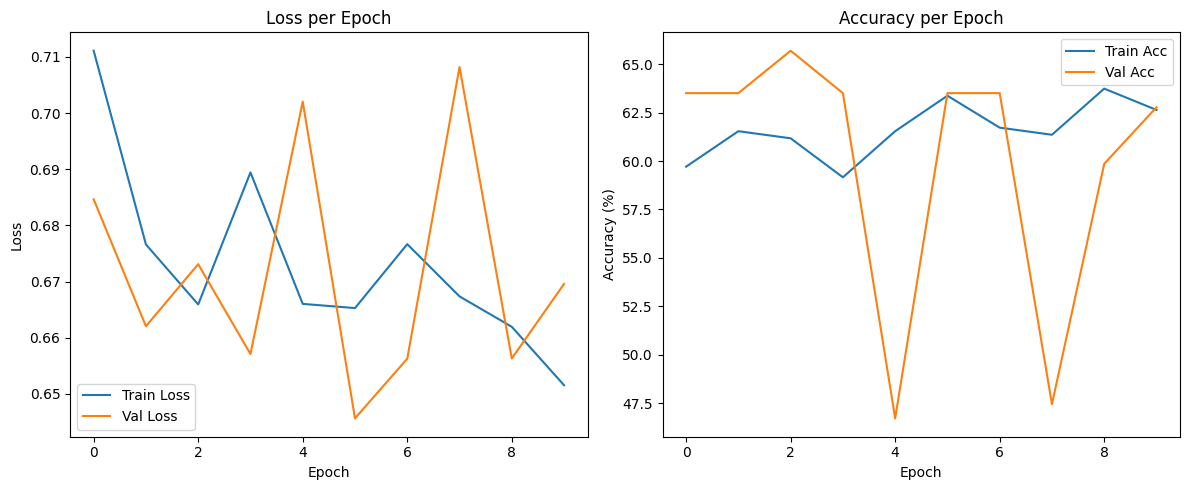

Saved final model.


In [23]:
# ----------------------------
# 1. Imports
# ----------------------------
import glob
import os
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from monai.networks.nets import resnet, densenet
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----------------------------
# 2. Dataset
# ----------------------------
class MRIDataset(Dataset):
    def __init__(self, file_paths, labels, target_shape=(64, 64, 64)):
        self.file_paths = file_paths
        self.labels = labels
        self.target_shape = target_shape
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label = self.labels[idx]

        # Load NIfTI
        img = nib.load(path).get_fdata()

        # Z-score normalization
        img = (img - img.mean()) / (img.std() + 1e-5)

        # Resample to target shape
        zoom_factors = [t / s for t, s in zip(self.target_shape, img.shape)]
        img = zoom(img, zoom_factors, order=1)

        # Add channel: [C=1, D, H, W]
        img = np.expand_dims(img, axis=0)

        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# ----------------------------
# 3. Main guard for Windows
# ----------------------------
if __name__ == "__main__":
    # ----------------------------
    # 3a. Load ADNI file paths and labels
    # ----------------------------
    label_map = {'CN': 0, 'MCI': 1}
    full_data = glob.glob("Dataset/*/*.nii.gz")
    labels_str = [os.path.basename(os.path.dirname(p)) for p in full_data]
    labels = [label_map[l] for l in labels_str]

    train_path, test_path, train_labels, test_labels = train_test_split(
        full_data, labels, test_size=0.2, random_state=42, stratify=labels
    )

    train_ds = MRIDataset(train_path, train_labels)
    test_ds = MRIDataset(test_path, test_labels)

    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=1, num_workers=0)

    # ----------------------------
    # 4. Device
    # ----------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ----------------------------
    # 5. MONAI 3D-ResNet10
    # ----------------------------
    """model = resnet.resnet10(
        spatial_dims=3,
        n_input_channels=1,
        num_classes=2
    ).to(device)"""

    model = resnet.resnet18(
            spatial_dims=3,
            n_input_channels=1,  # single-channel MRI
            num_classes=2        # CN vs MCI
        ).to(device)

    # ----------------------------
    # 6. Loss and optimizer
    # ----------------------------
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    # ----------------------------
    # 7. Mixed precision scaler
    # ----------------------------
    scaler = torch.amp.GradScaler("cuda")

    # ----------------------------
    # 8. Training loop
    # ----------------------------
    num_epochs = 10
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(test_loader)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}% | "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")

        scheduler.step()

    # ----------------------------
    # 9. Plot metrics
    # ----------------------------
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ----------------------------
    # 10. Save model
    # ----------------------------
    torch.save(model.state_dict(), './MONAI_3DResNet152_ADNI.pth')
    print("Saved final model.")
